In [1]:
import pickle
import numpy as np 
import torch 
from ClassificationModels.CNN_T import ResNetBaseline, UCRDataset
from tslearn.datasets import UCR_UEA_datasets

# Parameters

In [2]:
dataset='ElectricDevices'

# Load Data

In [3]:
train_x,train_y, test_x, test_y=UCR_UEA_datasets().load_dataset(dataset)
train_x = train_x.reshape(-1,1,  train_x.shape[-2])
test_x = test_x.reshape(-1,1,  test_x.shape[-2])

In [4]:
test_x.shape

(7711, 1, 96)

In [5]:
print(test_y.shape)

(7711,)


In [6]:
#enc1=sklearn.preprocessing.OneHotEncoder(sparse=False).fit(np.vstack((train_y.reshape(-1,1),test_y.reshape(-1,1))))
enc1=pickle.load(open(f'../../ClassificationModels/models/{dataset}/OneHotEncoder.pkl','rb'))

train_y=enc1.transform(train_y.reshape(-1,1))
test_y=enc1.transform(test_y.reshape(-1,1))
    

# Model Training

In [7]:
n_pred_classes =train_y.shape[1]
train_dataset = UCRDataset(train_x.astype(np.float64),train_y.astype(np.int64))
test_dataset = UCRDataset(test_x.astype(np.float64),test_y.astype(np.int64))
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=16,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=1,shuffle=False)
model = ResNetBaseline(in_channels=1, num_pred_classes=n_pred_classes)
model.load_state_dict(torch.load(f'../../ClassificationModels/models/{dataset}/ResNet'))
model.eval()
#fit(model,train_loader,test_loader)
#if dataset in os.listdir('./ClassificationModels/models/'):
#    print('Folder exists')
#else: 
#    os.mkdir(f'./ClassificationModels/models/{dataset}')
#torch.save(model.state_dict(), f'./ClassificationModels/models/{dataset}/ResNet')

#test_preds, ground_truth = get_all_preds(model, test_loader)
#ground_truth=np.argmax(ground_truth,axis=1)

#sns.set(rc={'figure.figsize':(5,4)})
#heatmap=confusion_matrix(ground_truth, test_preds)
#sns.heatmap(heatmap, annot=True)
#plt.savefig(f'./ClassificationModels/models/{dataset}/ResNet_confusion_matrix.png')
#plt.close()
#acc= accuracy_score(ground_truth, test_preds)
#a = classification_report(ground_truth, test_preds, output_dict=True)
#dataframe = pd.DataFrame.from_dict(a)
#dataframe.to_csv(f'./ClassificationModels/models/{dataset}/classification_report.csv', index = False)

ResNetBaseline(
  (layers): Sequential(
    (0): ResNetBlock(
      (layers): Sequential(
        (0): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(1, 64, kernel_size=(8,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (1): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(5,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
        (2): ConvBlock(
          (layers): Sequential(
            (0): Conv1dSamePadding(64, 64, kernel_size=(3,), stride=(1,))
            (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
          )
        )
      )
      (residual): Sequential(
        (0): Conv1dSamePadding(1, 64, kernel_size=(1,)

# Explanation Algo

In [8]:
explained_instance = train_x[0]
nb_interpretable_feature = 10
explanation_size = 5
nb_neighbors = 1000
learning_process_name = 'Lime'
transform_name = 'straight_line'
model_to_explain=model

In [9]:
from TSInterpret.InterpretabilityModels.leftist.leftist import LEFTIST

2022-06-29 08:33:32.933328: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-29 08:33:32.933362: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [10]:
leftist = LEFTIST(model_to_explain,(test_x,None),mode='feat', backend='PYT')

In [11]:
explanations = leftist.explain(np.array(explained_instance),1000,explanation_size=explanation_size,learning_process_name='Lime',transform_name='straight_line')
#,transform_name='mean'

/media/jacqueline/Data/TSInterpret/TSInterpret/Models/PyTorchModel.py:32: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  y_pred = torch.nn.functional.softmax(out).detach().numpy()


feat
NOT Time mode
-1
1
0


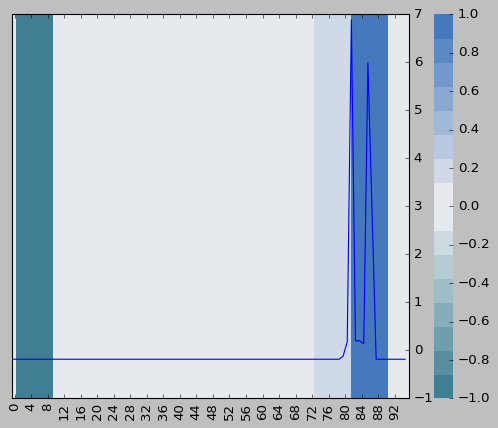

In [12]:
#sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)
leftist.plot(np.array([explained_instance]),np.array([explanations[1]]))

In [13]:
import seaborn as sns
sns.choose_diverging_palette(as_cmap=False)

interactive(children=(IntSlider(value=220, description='h_neg', max=359), IntSlider(value=10, description='h_p…

[(0.2519971417644415, 0.4987337088076726, 0.5751602783606602),
 (0.43156001218774975, 0.6160490836499025, 0.6735874169971766),
 (0.611122882611058, 0.7333644584921324, 0.7720145556336929),
 (0.7906857530343663, 0.8506798333343624, 0.8704416942702093),
 (0.95, 0.95, 0.95),
 (0.9282549678814984, 0.7863704363662967, 0.7963965173228867),
 (0.9022582584936525, 0.6005186021022944, 0.622400049291663),
 (0.8762615491058064, 0.4146667678382919, 0.44840358126043944),
 (0.8510408608937171, 0.23436274952246883, 0.2796010376480583)]

In [14]:
sns.choose_colorbrewer_palette('diverging')

interactive(children=(Dropdown(description='name', options=('RdBu', 'RdGy', 'PRGn', 'PiYG', 'BrBG', 'RdYlBu', …

[(0.6922722029988467, 0.09227220299884642, 0.16770472895040373),
 (0.8392156862745099, 0.376470588235294, 0.3019607843137253),
 (0.9545559400230679, 0.641753171856978, 0.5057285659361783),
 (0.9921568627450982, 0.8588235294117645, 0.7803921568627449),
 (0.9657054978854286, 0.9672433679354094, 0.9680891964628989),
 (0.8196078431372551, 0.8980392156862745, 0.9411764705882353),
 (0.5664744329104192, 0.7687043444828916, 0.8685121107266438),
 (0.26274509803921564, 0.576470588235294, 0.7647058823529411),
 (0.1272587466359093, 0.39584775086505203, 0.6687427912341407)]